In [73]:
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import torchvision
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torch.nn.functional as F
import numpy as np
import copy
from PIL import Image

In [74]:
transform = transforms.Compose([transforms.ToTensor()])
data_train = datasets.MNIST('./data', 
                            train = True,
                            download = True,
                            transform = transform
                           )
data_test = datasets.MNIST('./data',
                           train = False,
                           download = False, 
                           transform = transform
                          )

In [75]:
traindata = DataLoader(data_train, batch_size = 100, shuffle = True)
testdata = DataLoader(data_test, batch_size = 100, shuffle = True)

In [76]:
dataiter = iter(traindata)
data = next(dataiter)
features, labels = data

In [77]:
print('Размер изображения', features[0].shape)

Размер изображения torch.Size([1, 28, 28])


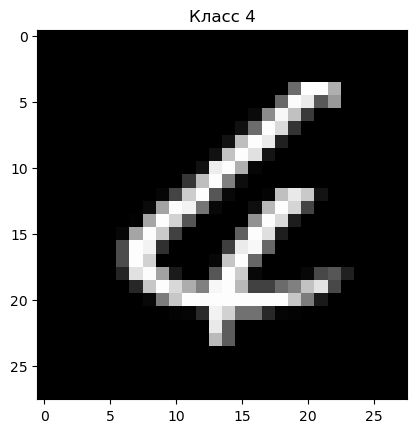

In [78]:
plt.imshow(torch.squeeze(features[0]), cmap = 'gray')
plt.title('Класс '+ str(labels[0].item()))
plt.show()

In [84]:
torch.set_printoptions(threshold=10_000)
print(torch.squeeze(features[0]))

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

In [7]:
print('Количество классов', len(torch.unique(labels)))

Количество классов 10


In [8]:
model = torch.nn.Sequential(
    torch.nn.Conv2d(1, 32, kernel_size = 3, padding = 1, padding_mode = 'replicate'),
    torch.nn.MaxPool2d(kernel_size=2),
    torch.nn.ReLU(),
    torch.nn.Conv2d(32, 64, kernel_size = 3, padding = 1, padding_mode = 'replicate'),
    torch.nn.MaxPool2d(kernel_size=2),
    torch.nn.ReLU(),
    torch.nn.Conv2d(64, 128, kernel_size = 3, padding = 1, padding_mode = 'replicate'),
    torch.nn.MaxPool2d(kernel_size=2),
    torch.nn.ReLU(),
    torch.nn.Flatten(),
    torch.nn.Dropout(0.2),
    torch.nn.Linear(1152, 10)
    )
loss = torch.nn.CrossEntropyLoss()
trainer = torch.optim.Adam(model.parameters(), lr=0.001)

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)
print(f"Model is on device: {next(model.parameters()).device}")

Model is on device: cuda:0


In [10]:
num_epochs = 50
for epoch in range(1, num_epochs + 1):
    losses_per_epoch = []
    for X, y in traindata:
        X, y = X.to(device), y.to(device)
        trainer.zero_grad()
        l = loss(model(X), y)
        losses_per_epoch.append(l.item())
        l.backward()
        trainer.step()
    if epoch % 5 == 0:
        print('epoch %d, loss: %f' % (epoch, np.mean(losses_per_epoch)))

epoch 5, loss: 0.027959
epoch 10, loss: 0.015024
epoch 15, loss: 0.009423
epoch 20, loss: 0.006522
epoch 25, loss: 0.004593
epoch 30, loss: 0.004665
epoch 35, loss: 0.003904
epoch 40, loss: 0.002420
epoch 45, loss: 0.001595
epoch 50, loss: 0.002641


In [11]:
y_pred = []
y_true = []
for X, y in testdata:
    X, y = X.to(device), y.to(device)
    y_pred_iter = model(X)
    y_pred.extend(y_pred_iter.detach())
    y_true.extend(y.detach())

y_pred = torch.Tensor([torch.argmax(x) for x in y_pred])
y_true = torch.Tensor(y_true)

In [12]:
from sklearn.metrics import accuracy_score
print('Точность на тестовой выборке:', accuracy_score(y_true, y_pred))

Точность на тестовой выборке: 0.9923


In [27]:
# сохранить обученную модель
torch.save(model.state_dict(), 'mnist_model.pth')

In [32]:
# Загрузить модель
model.load_state_dict(torch.load('mnist_model.pth'))

<All keys matched successfully>

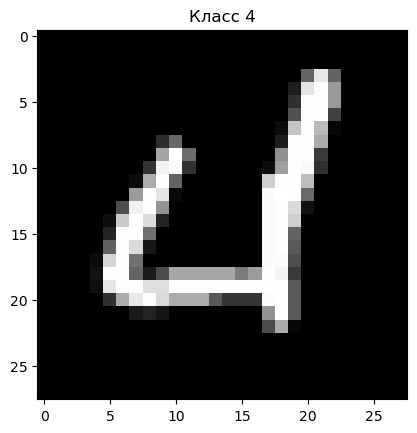

RuntimeError: mat1 and mat2 shapes cannot be multiplied (128x9 and 1152x10)

In [46]:
index = 10
plt.imshow(torch.squeeze(features[index]), cmap = 'gray')
plt.title('Класс '+ str(labels[index].item()))
plt.show()

x_pred = copy.copy(features[index])
x_pred = x_pred.to(device)
y_pred = model(x_pred)

y_pred.extend(y_pred.detach())
y_true.extend(y.detach())
print(y_true)